# sampling inference for Gaussian process regression

In [1]:
import gpie
print(gpie.__version__)

0.1.3


In [2]:
import numpy as np
from math import exp, log, pi
from matplotlib import pyplot as plt

In [3]:
from gpie.infer import LogDensity, Gaussian, MarkovChainMonteCarloSampler
from gpie.kernel import RBFKernel, WhiteKernel, GaussianProcessRegressor

In [4]:
# fix random seed
np.random.seed(1)

In [5]:
# generate dataset
# a) training set
n = 50
X_train = np.random.uniform(0, 10, n)[:, np.newaxis]
y_train = 5. * np.sin(pi * X_train[:, 0]) + np.random.normal(0., 1., n)
# b) test set
X_test = np.linspace(0, 10, 200)[:, np.newaxis]
y_test_mean = 5. * np.sin(pi * X_test[:, 0])

In [6]:
# initialize GPR model
a1 = 4.0
l = 1.8
a2 = 1.0
gpr = GaussianProcessRegressor(a1 * RBFKernel(l=l) + a2 * WhiteKernel())
gpr

GaussianProcessRegressor(kernel=2**2 * RBFKernel(l=1.8) + 1**2 * WhiteKernel)

In [7]:
# train GPR model
gpr.fit(X_train, y_train)

GaussianProcessRegressor(kernel=4.82**2 * RBFKernel(l=0.507) + 0.722**2 * WhiteKernel)

### sample GP prior and posterior

In [8]:
# with the current hypers, ...
# ... what is the prior distribution p(y_test)
y_test_prior = gpr.prior_predictive(X_test, n_samples=6)
# ... what is the posterior distribution p(y_test|y_train)
y_test_posterior = gpr.posterior_predictive(X_test, n_samples=4)

../gpie/kernel/gaussian_process.py:236: UserWarning: posterior covariance matrix has negative elements. possibly numerical issues. correcting to 0.
  warnings.warn('posterior covariance matrix has negative elements. '


In [9]:
# visualization
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 200
colors = plt.cm.jet(np.linspace(.25, .75, 6))

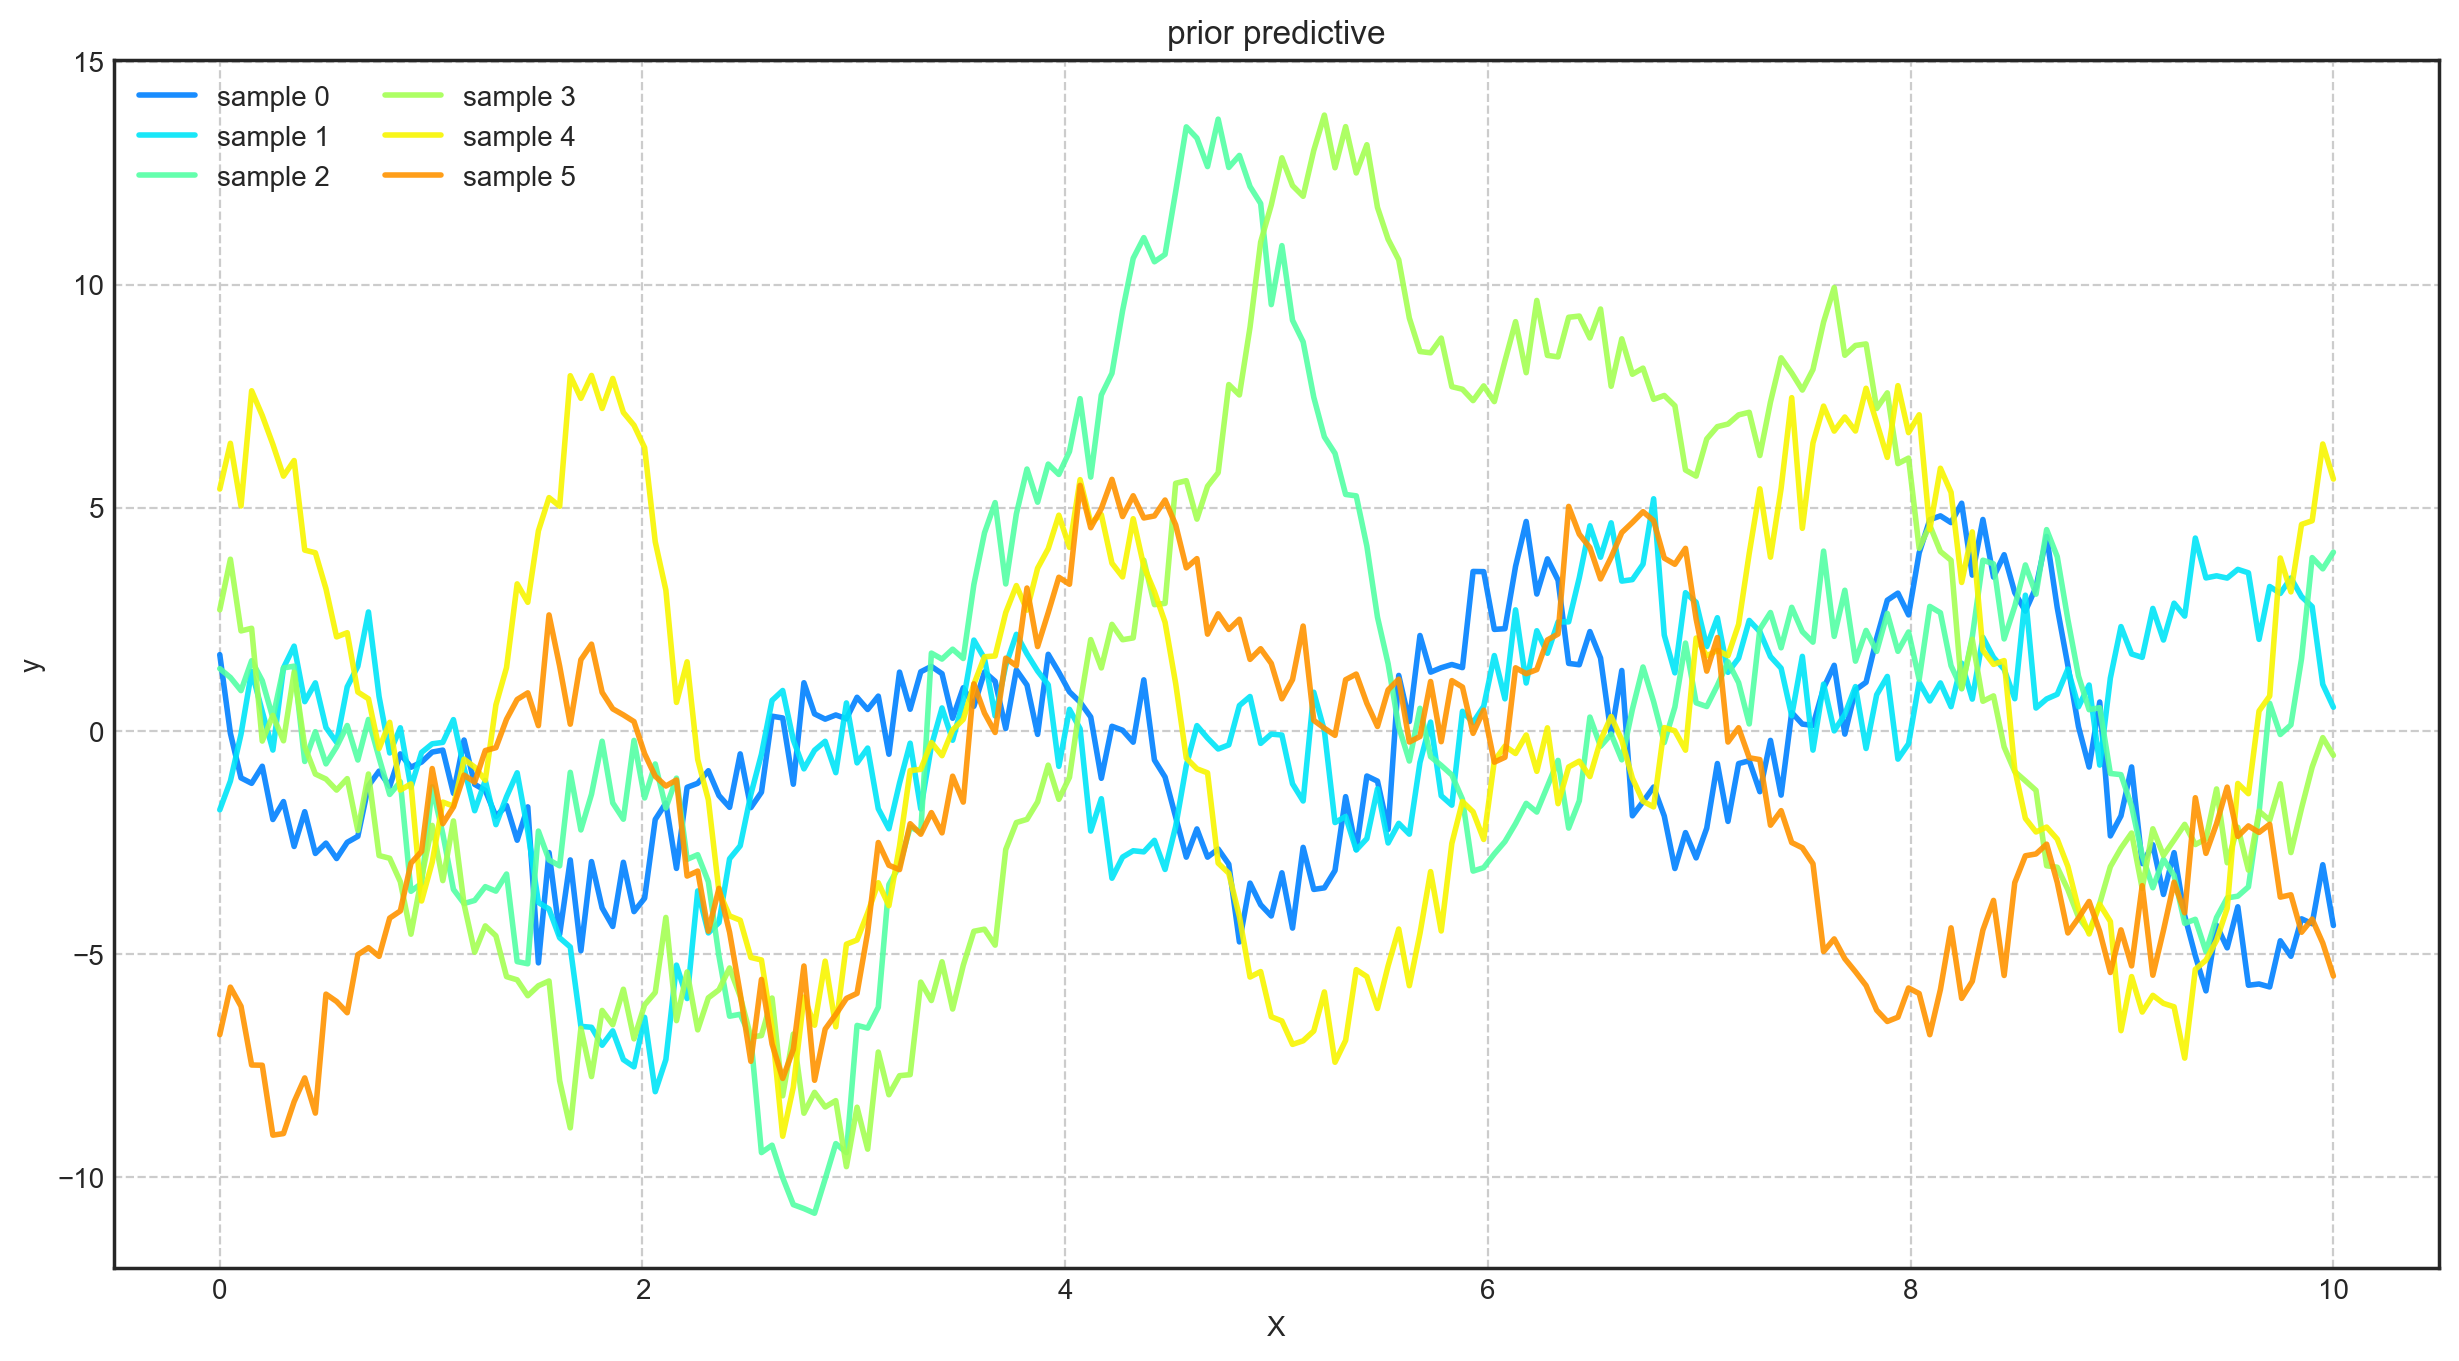

In [10]:
# prior predictive
for i, y in enumerate(y_test_prior):
    plt.plot(X_test.flatten(), y, color=colors[i], linewidth=2, alpha=0.9, label='sample {}'.format(i))

plt.grid(linestyle='--')
plt.legend(loc=2, ncol=2)
plt.title('prior predictive')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

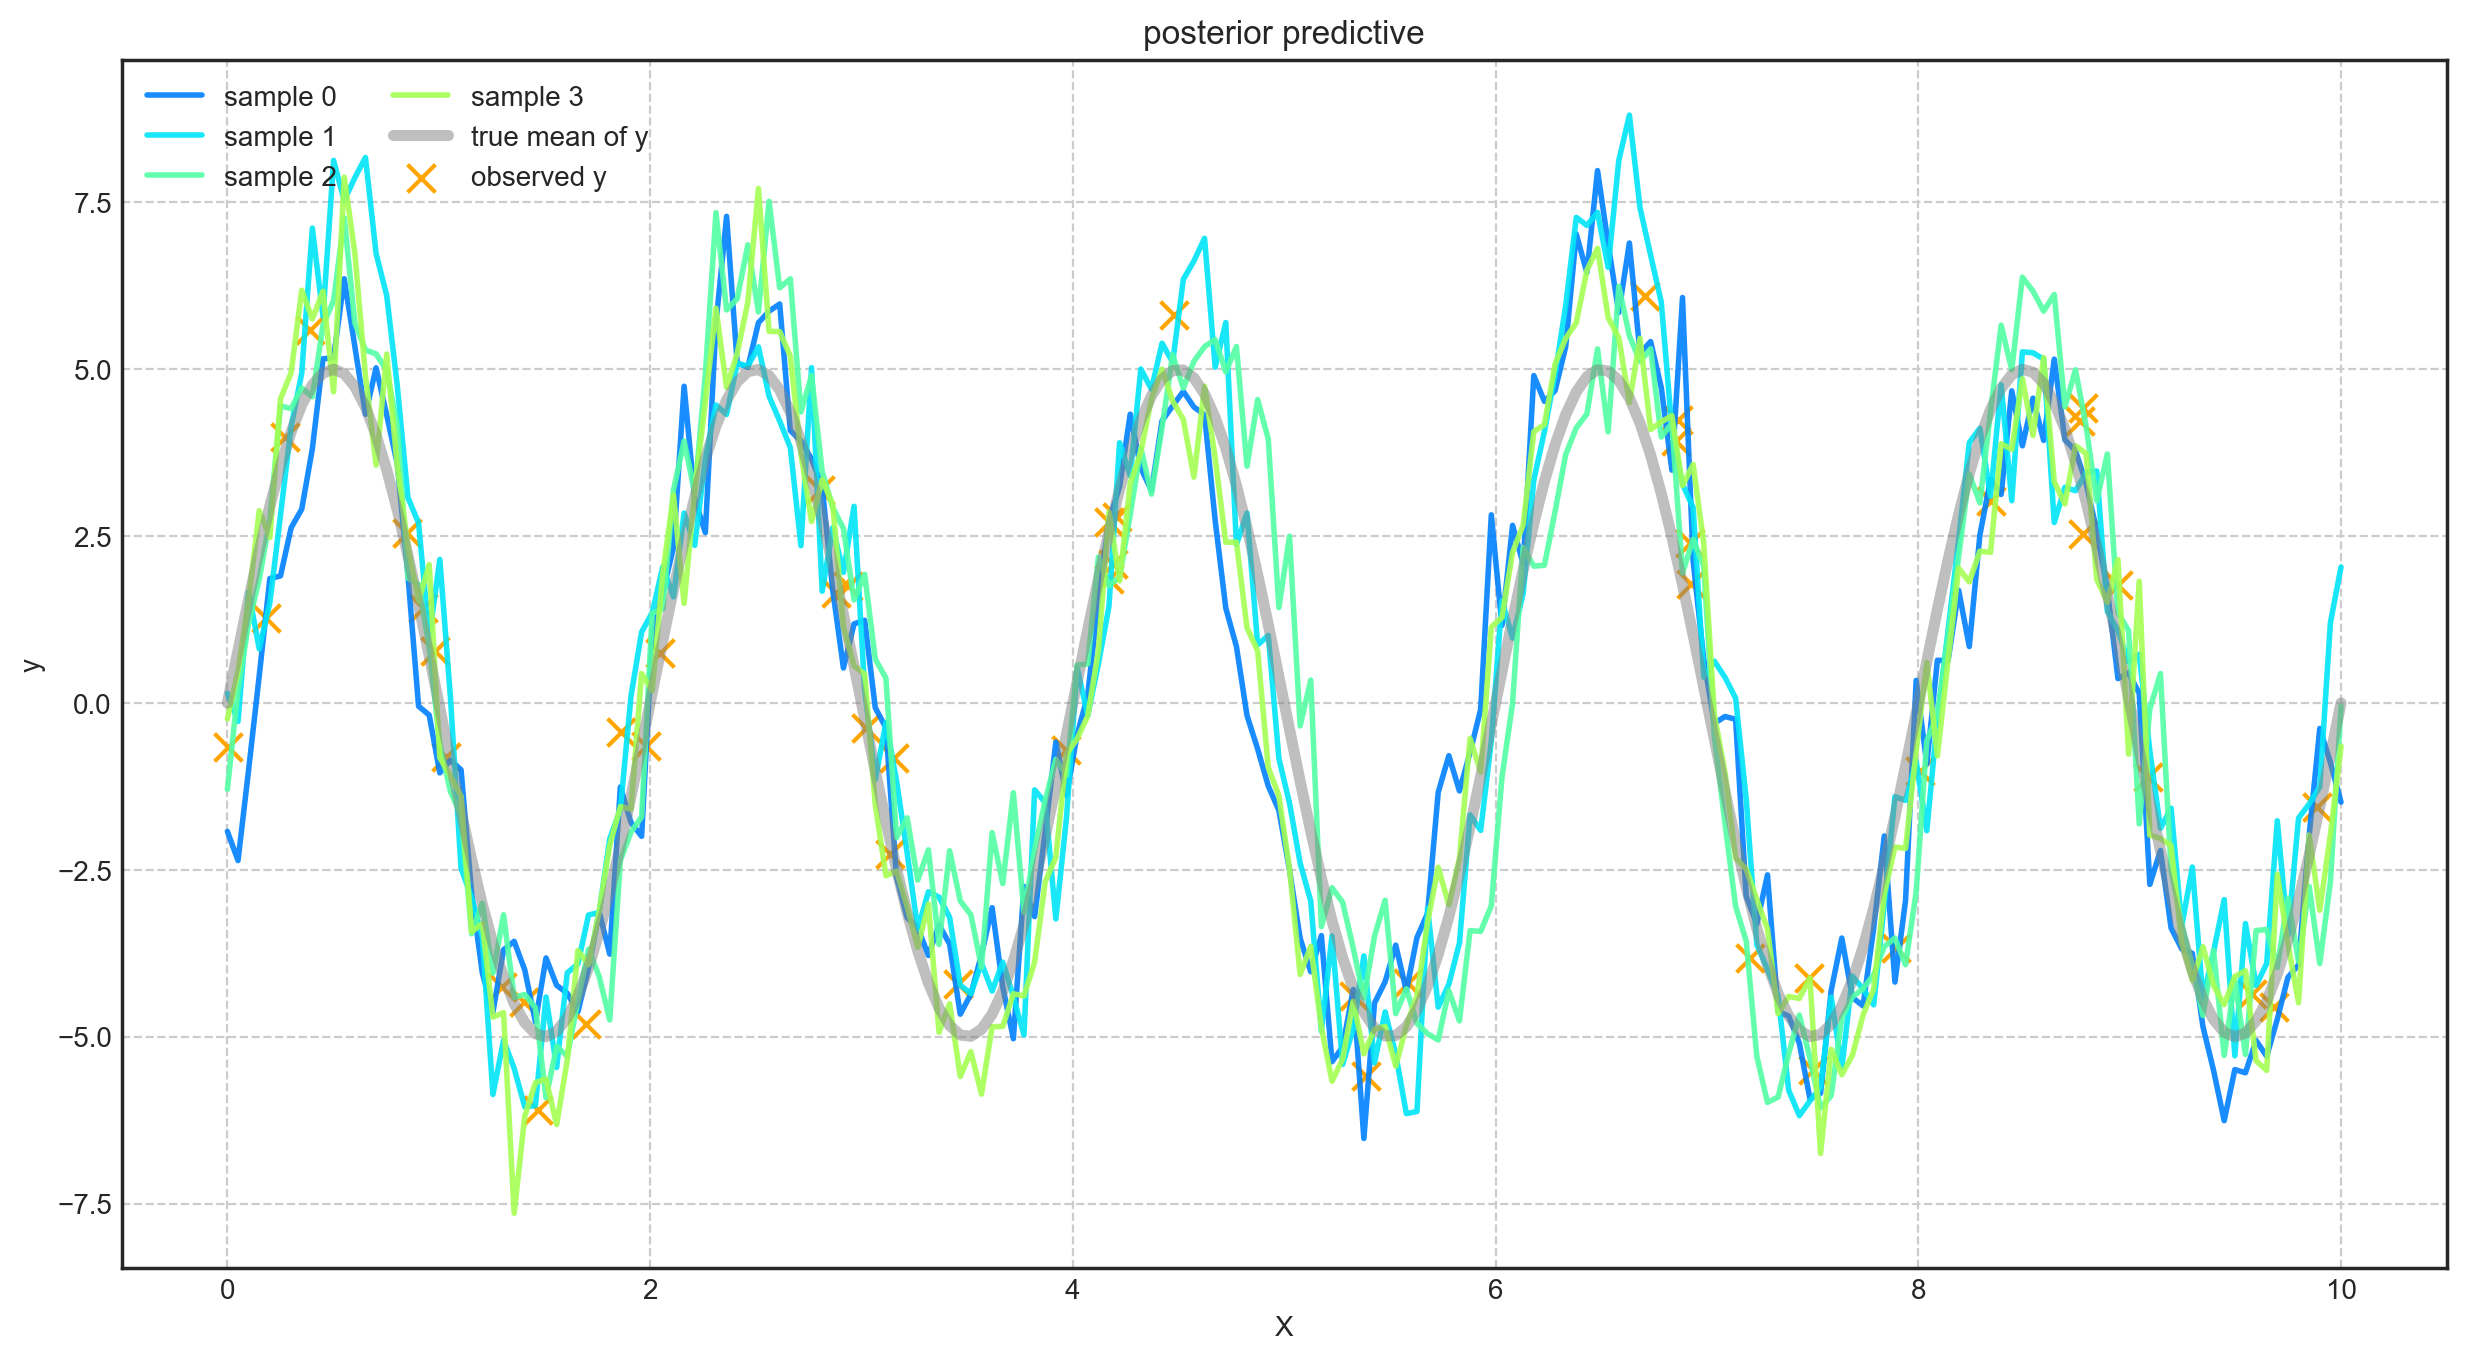

In [11]:
# posterior predictive
for i, y in enumerate(y_test_posterior):
    plt.plot(X_test.flatten(), y, color=colors[i], linewidth=2, alpha=0.9, label='sample {}'.format(i))

plt.plot(X_test.flatten(), y_test_mean, color='gray', linewidth=4, alpha=0.5, label='true mean of y')
plt.scatter(X_train.flatten(), y_train, s=100, c='orange', marker='x', label='observed y')

plt.grid(linestyle='--')
plt.legend(loc=2, ncol=2)
plt.title('posterior predictive')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

### sample posterior distribution of hyperparamters

In [12]:
# invoke MCMC sampler
hyper_posterior = gpr.hyper_posterior(n_samples=10000, n_burns=5000)

In [13]:
""" caveat about parameter representation
For numerical considerations, internal paramterization differs from externals,
usually linked via logarithm. e.g., RBF(l=2.) internally stores log(l) = 0.693
I am still figuring out a conversion method between two representations, until
which I'll just manually convert them
"""
print('external parameterization: ', gpr)
print('internal parameterization: ', gpr.thetas.values)
print('exp(internal) == external: ', np.exp(gpr.thetas.values))

external parameterization:  GaussianProcessRegressor(kernel=4.82**2 * RBFKernel(l=0.507) + 0.722**2 * WhiteKernel)
internal parameterization:  [ 3.14403605 -0.67881935 -0.6520169 ]
exp(internal) == external:  [23.19730367  0.50721548  0.52099392]


In [14]:
a1 = np.exp(hyper_posterior[:, 0])
l  = np.exp(hyper_posterior[:, 1])
a2 = np.exp(hyper_posterior[:, 2])

In [15]:
# visualization
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.dpi'] = 200

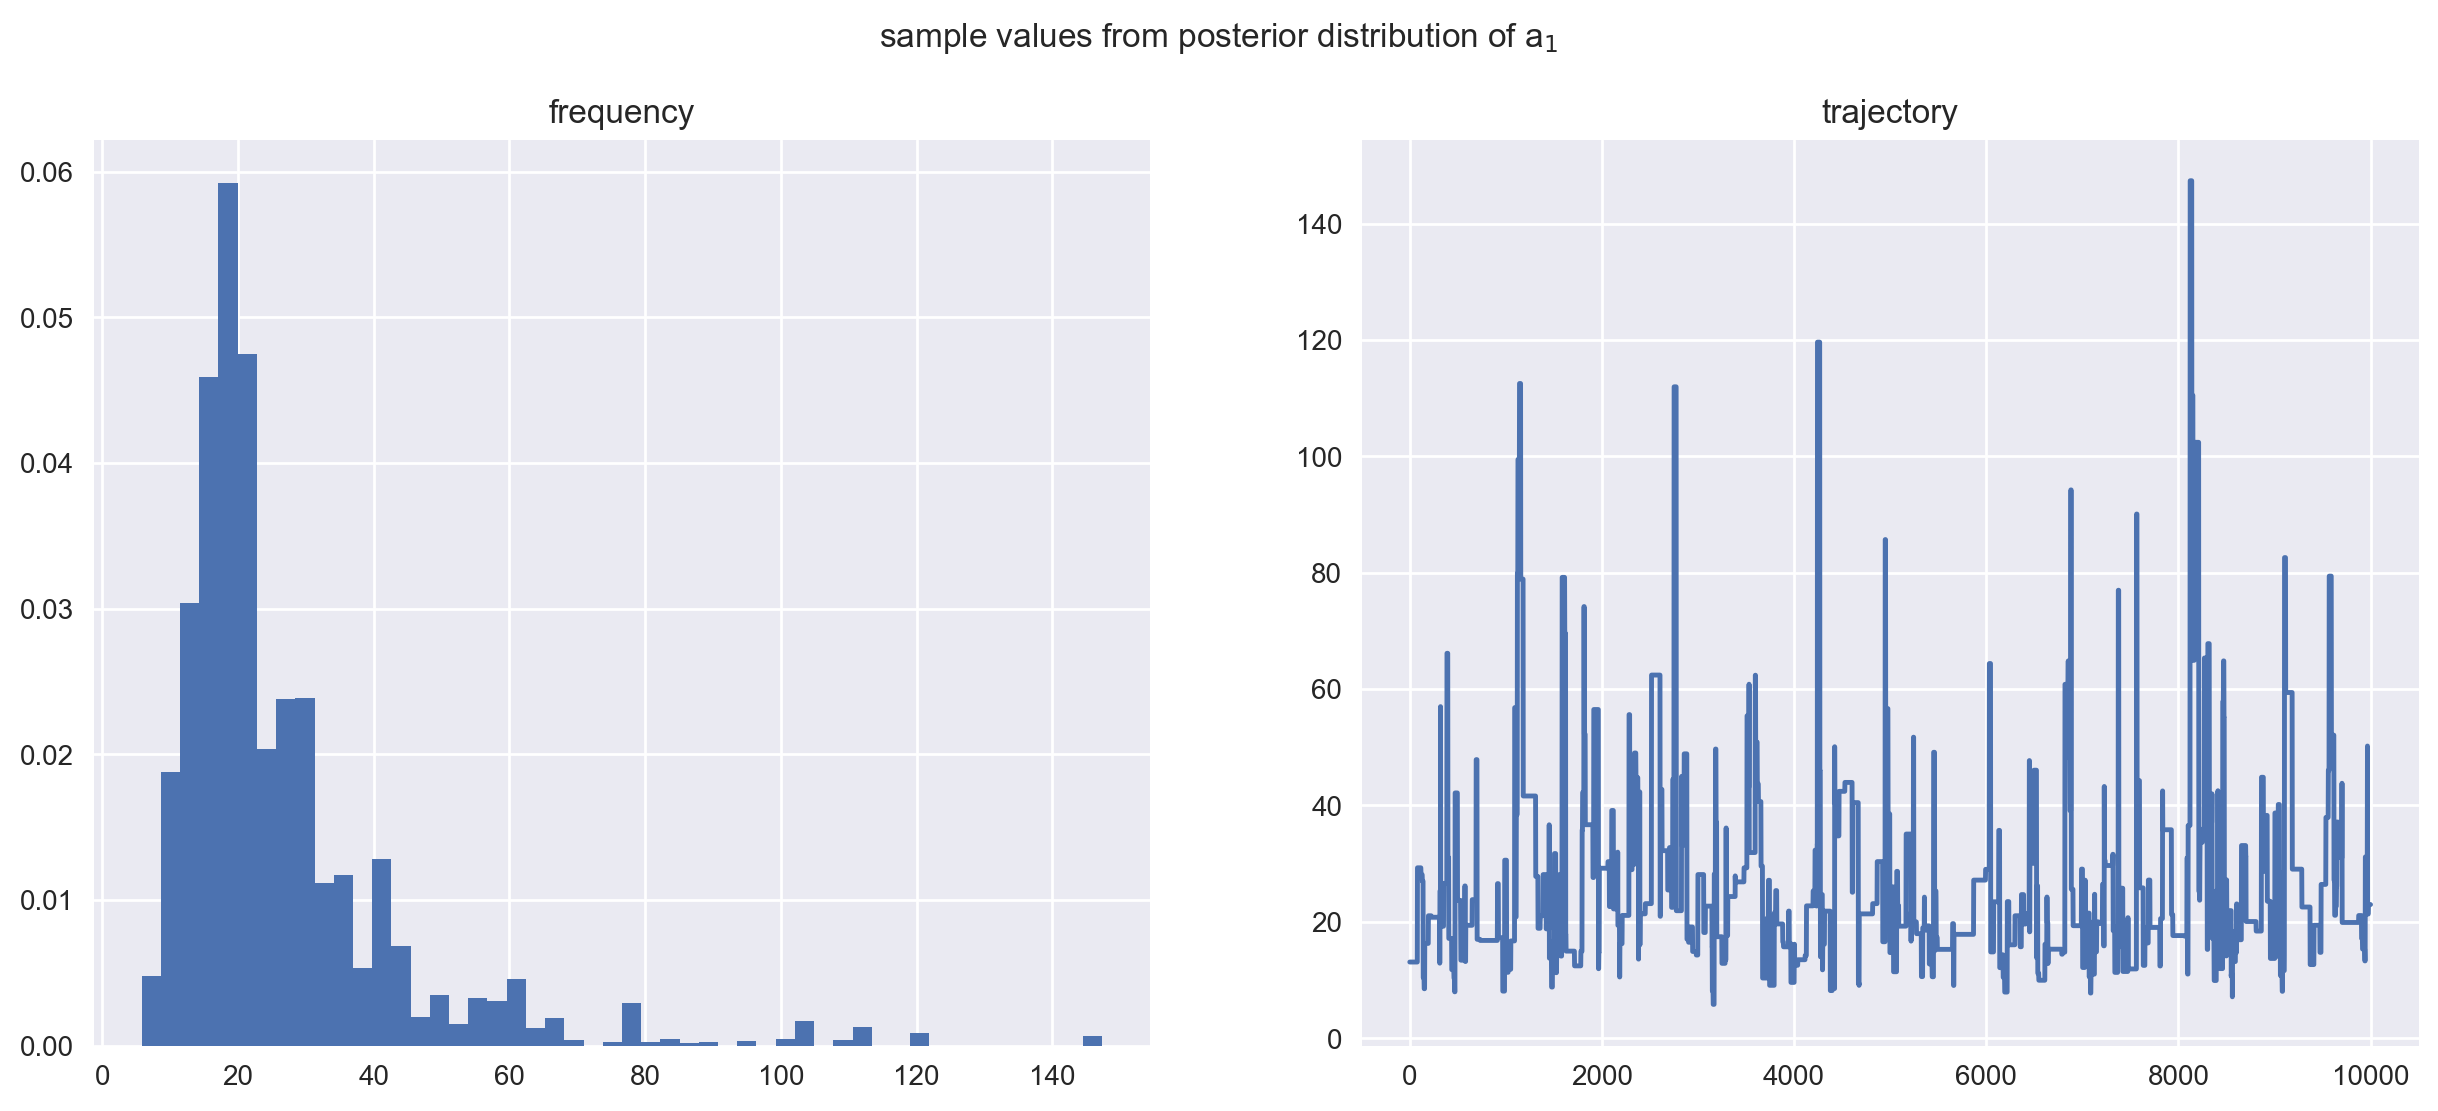

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(a1, bins=50, density=True)
ax2.plot(np.arange(0, 10000, 1), a1)
ax1.set_title('frequency')
ax2.set_title('trajectory')
plt.suptitle('sample values from posterior distribution of a$_1$')
plt.show()

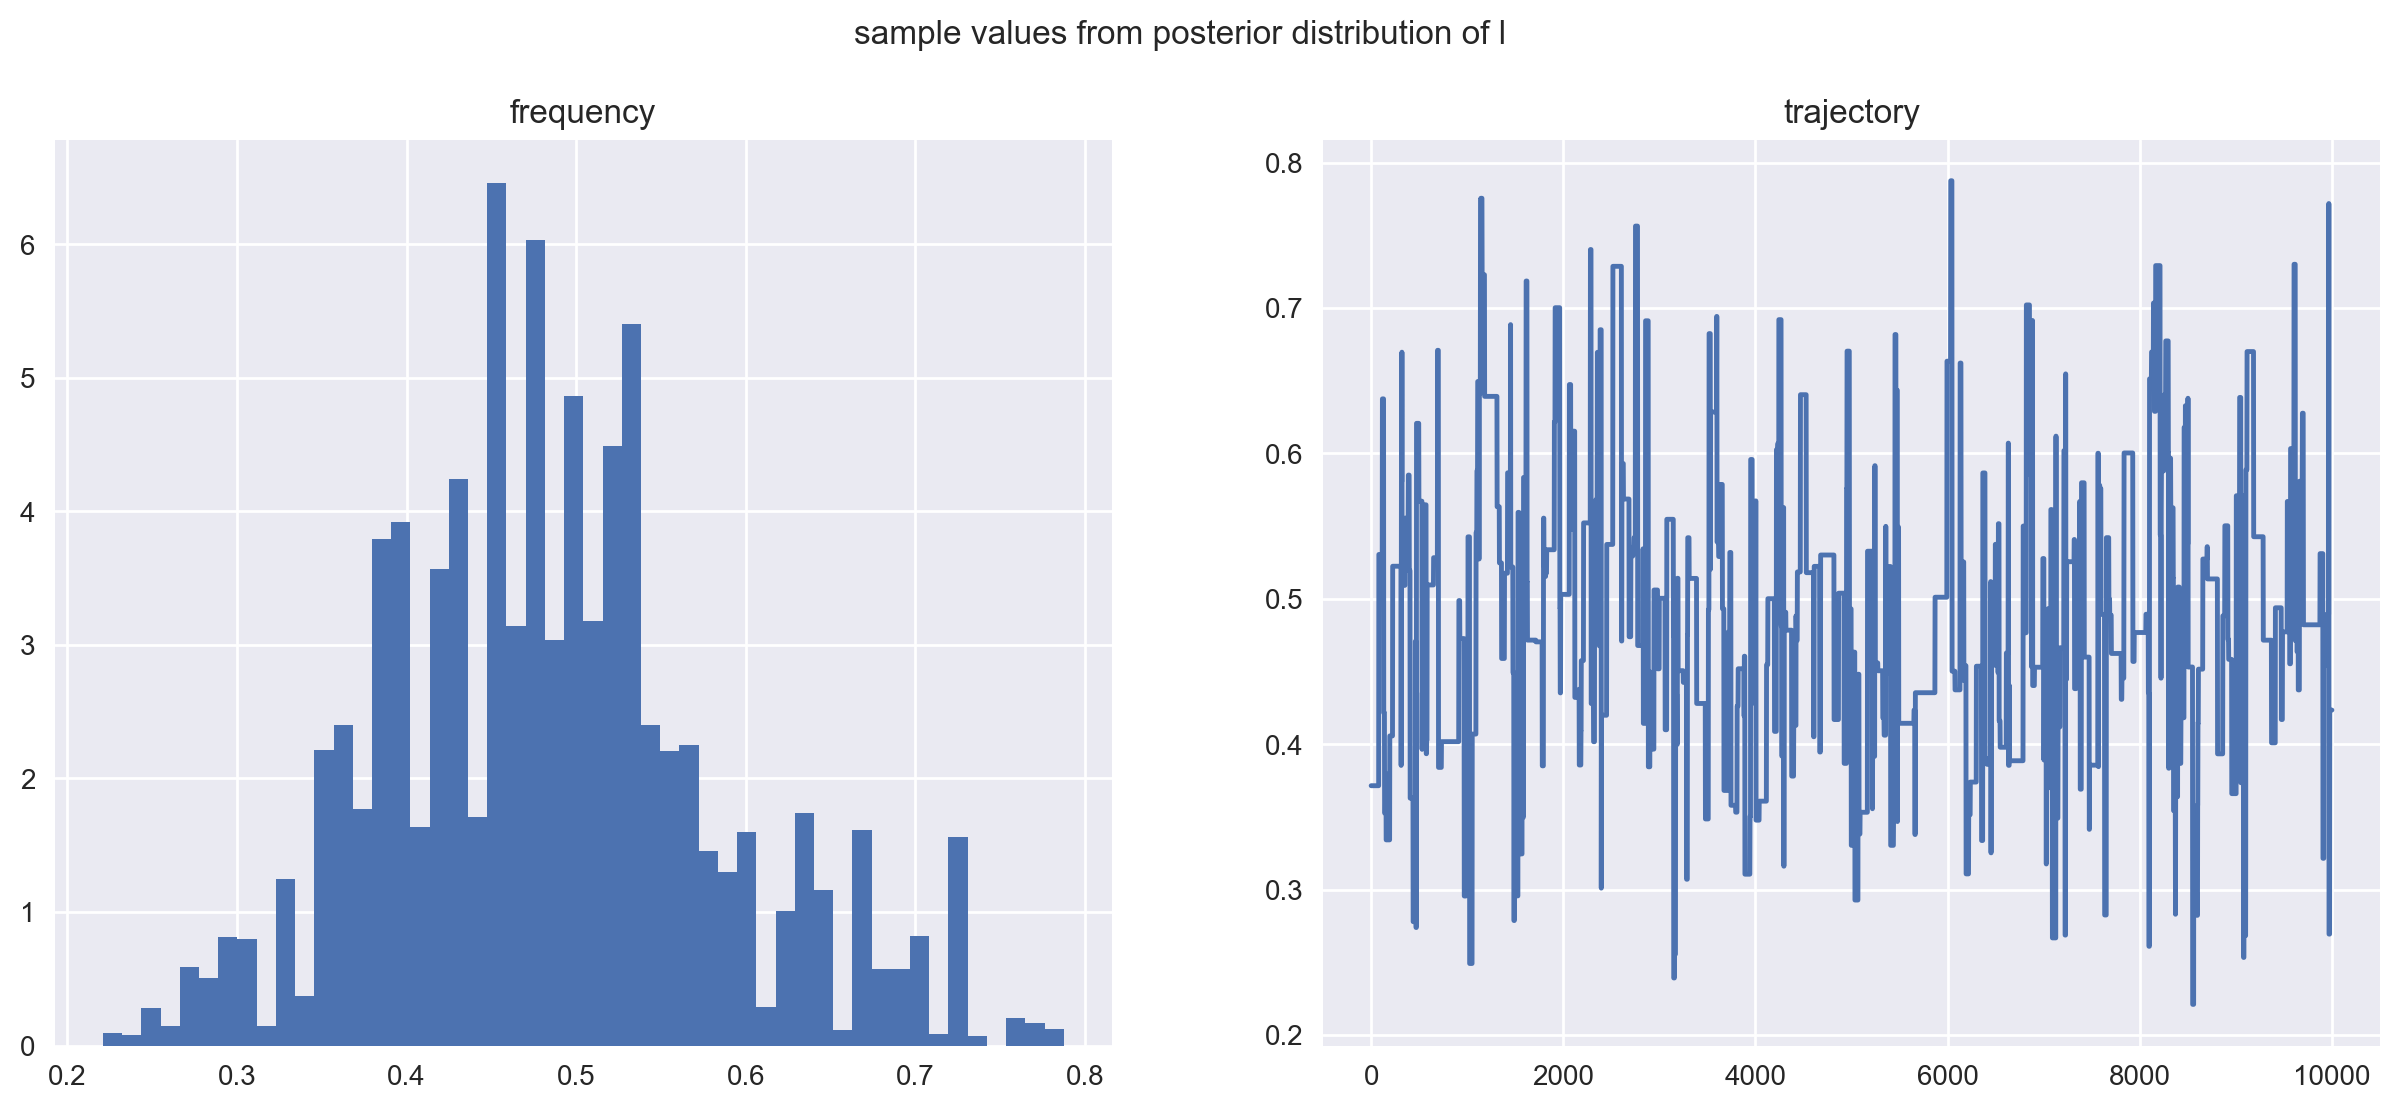

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(l, bins=50, density=True)
ax2.plot(np.arange(0, 10000, 1), l)
ax1.set_title('frequency')
ax2.set_title('trajectory')
plt.suptitle('sample values from posterior distribution of l')
plt.show()

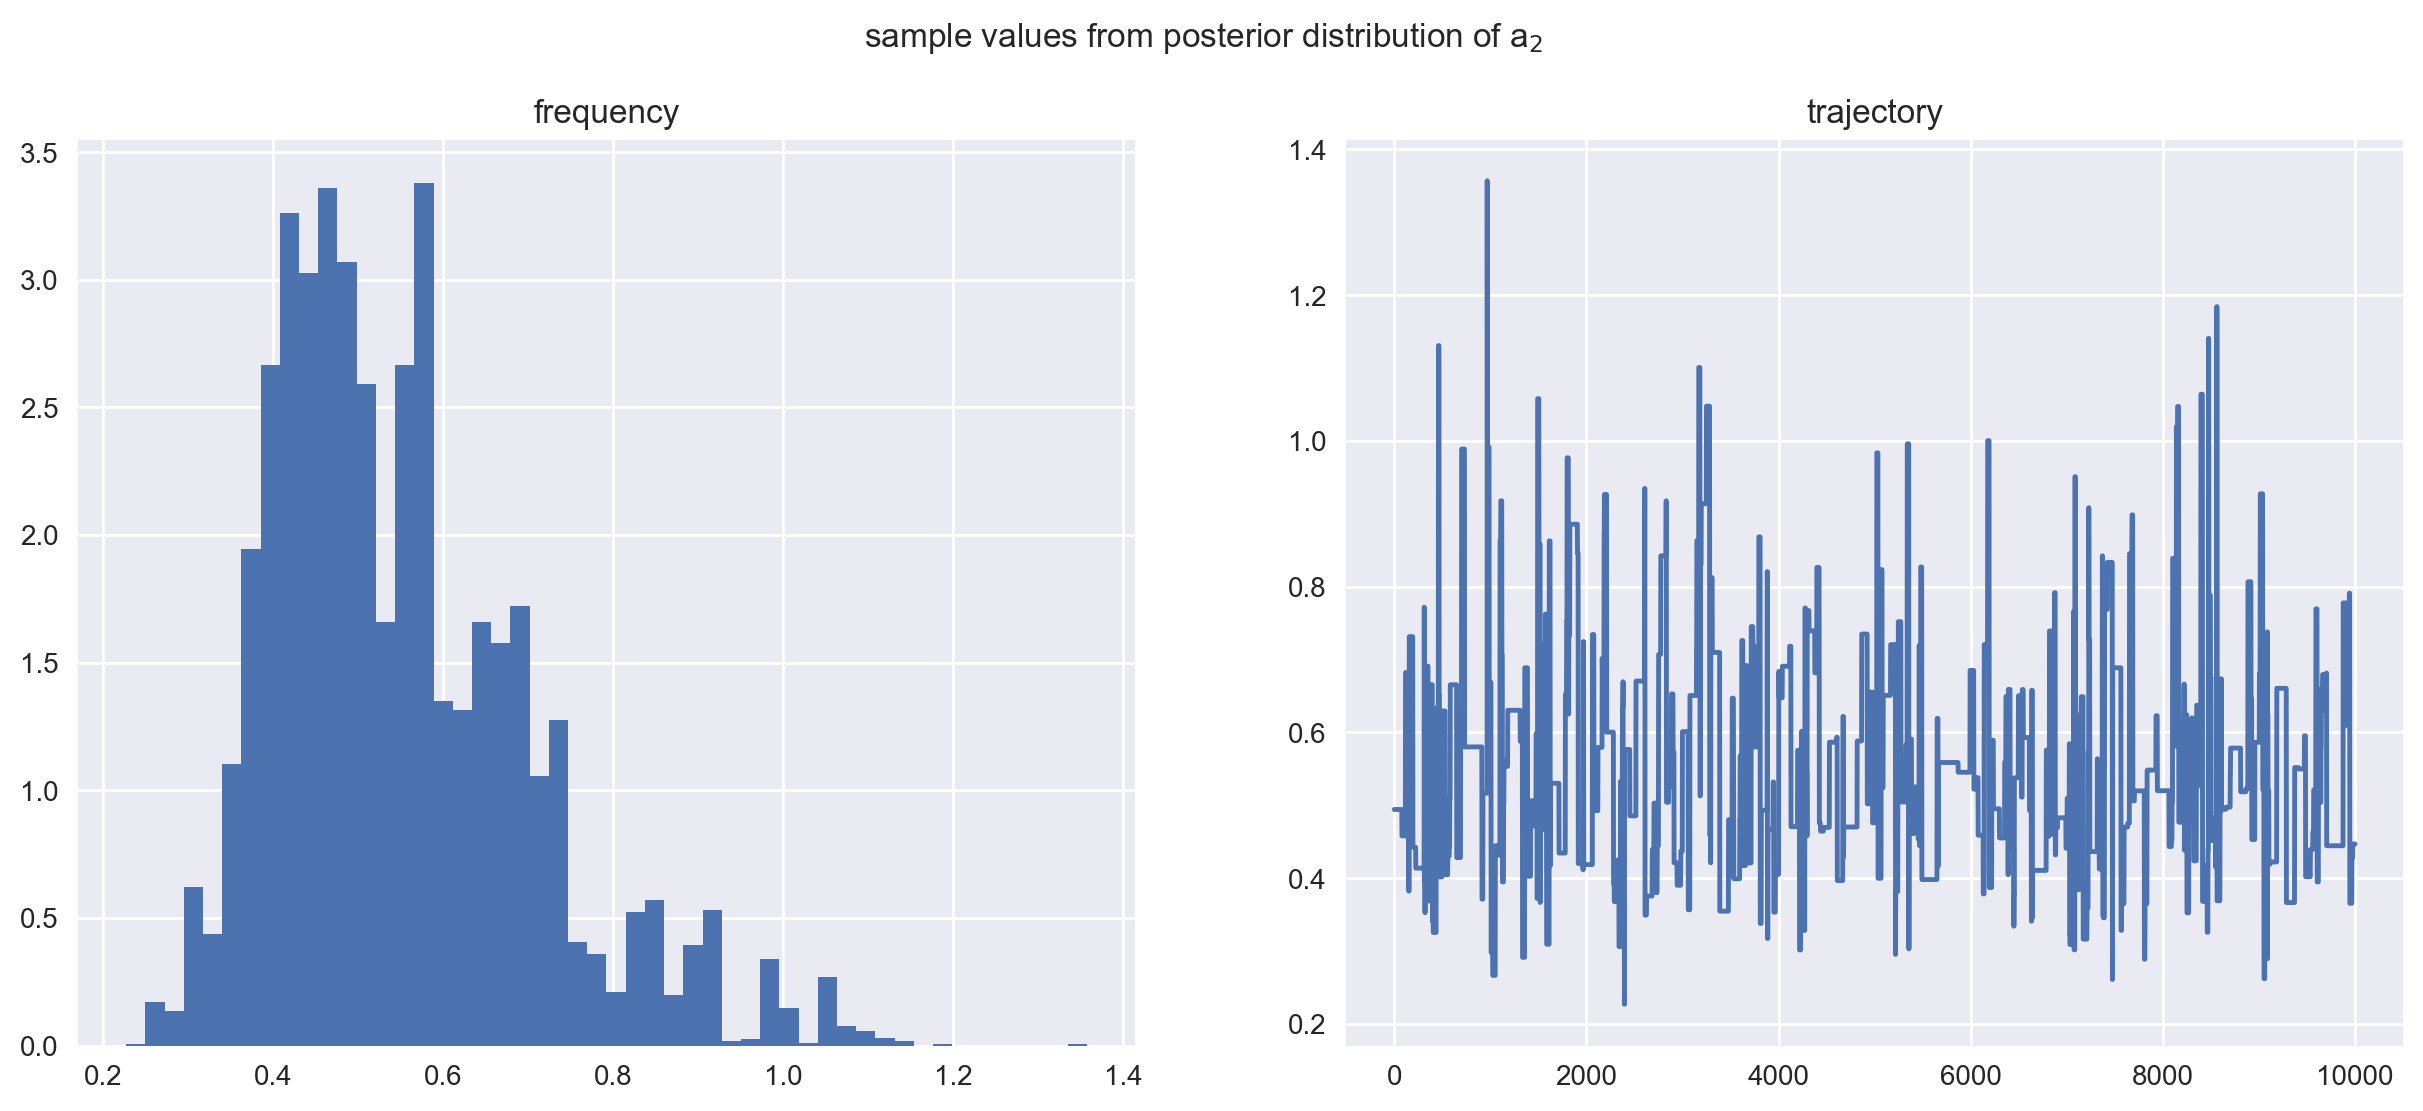

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(a2, bins=50, density=True)
ax2.plot(np.arange(0, 10000, 1), a2)
ax1.set_title('frequency')
ax2.set_title('trajectory')
plt.suptitle('sample values from posterior distribution of a$_2$')
plt.show()